In [109]:
import math
import numpy as np

def calculate_user_reputation(params,user_index):
    """计算用户的信誉分数"""
    # 获取必要的参数
    prev_rep = params.get('reputation_table')[user_index]  # Rep(t-1)
    _lambda = params.get('lambda')  # 信誉调整系数
    # 1. 计算WR 
    # 1.1 计算Txdt (交易因子)
    txn_table = params.get('txn_table')
    txn = txn_table[user_index] # 用户的情报购买量
    txn_avg = np.mean(txn_table)
    txd = 0 #用户情报交易差
    if txn > txn_avg:
        txd = (txn - txn_avg)

        
    # 1.2 计算Updt (上传因子)
    upn_table = params.get('upn_table')
    upn = upn_table[user_index]
    upn_avg = np.mean(upn_table)
    upd = 0 #用户情报上传差
    if upn > upn_avg:
        upd = (upn - upn_avg)
        
    # 1.3 获取其他因子
    user_level = params.get('user_level_table')[user_index]  # 用户等级
    theta = calculate_user_eval_similarity_by_matrix(params,user_index)  # 评价相似度,相似度过高则为恶意用户组
    
    # 计算WRt
    m1 = params.get('m1')  # 交易因子权重
    m2 = params.get('m2')  # 上传因子权重
    m3 = params.get('m3')  # 用户等级权重
    m4 = params.get('m4')  # 评价相似度权重
    
    new_WR = 1 - m1 * txd + m2 * upd + m3 * user_level - m4 * theta
    #更新WR
    params['WR_table'][user_index] = new_WR
    #更新WR_avg
    params['WR_avg'] = np.mean(params.get('WR_table'))
    # 计算最终信誉分数 (公式1)
    new_reputation = prev_rep + _lambda * (new_WR - params['WR_avg'])
    #保存小数位
    new_reputation = round(new_reputation, 5)
    #归一化
    normalized_reputation = 1
    if max(params['reputation_table']) - min(params['reputation_table']) > 0:
        normalized_reputation = (new_reputation - min(params['reputation_table'])) / (max(params['reputation_table']) - min(params['reputation_table']))
    #更新信誉分数
    params['reputation_table'][user_index] = new_reputation
    params['normalized_reputation_table'][user_index] = normalized_reputation
    return new_reputation

def calculate_user_eval_similarity(params, user_index):
    """计算用户的评价相似度
        相似度越高，值越大
    Args:
        params: 参数字典
        user_index: 用户索引
        
    Returns:
        float: 用户的评价相似度
    """
    # 获取必要参数
    eval_score_table = np.array(params.get('eval_score_table'))
    user_evals_vector = eval_score_table[:, user_index]  # 当前用户的评价(第user_index列)
    user_exist_eval_index = [i for i,score in enumerate(user_evals_vector) if score > 0] #只取用户评价过的情报
    # 计算当前用户评价与其他用户评价的相似度
    total_similarity = 0
    num_users = len(params.get('all_user_list'))
    
    for i in range(num_users):
        if i != user_index:
            # 其他用户评价向量
            other_user_evals_vector = eval_score_table[:, i]
            other_user_exist_evals_vector = [other_user_evals_vector[j] for j in user_exist_eval_index]
            # 计算两个用户评价向量的点积
            dot_product = np.sum(user_evals_vector * other_user_evals_vector)
            # 计算向量模长
            norm_user = np.sqrt(np.sum(user_evals_vector ** 2))
            norm_other = np.sqrt(np.sum(other_user_evals_vector ** 2))
            # 计算余弦相似度
            if norm_user > 0 and norm_other > 0:
                similarity = dot_product / (norm_user * norm_other)
                total_similarity += similarity
    
    # 计算平均相似度
    avg_similarity = (total_similarity / (num_users - 1))if num_users > 1 else 0
    avg_similarity = round(avg_similarity, 5)
    #更新用户评价相似度
    params['user_eval_similarity_table'][user_index] = avg_similarity
    return avg_similarity

def calculate_user_eval_similarity_by_matrix(params,user_index):
    """计算用户的评价相似度(矩阵运算优化版本)
    Args:
        params: 参数字典
        user_index: 用户索引
    Returns:
        float: 用户的评价相似度
    """
    # 获取评分矩阵
    eval_score_table = np.array(params.get('eval_score_table'))
    
    # 获取当前用户的评价向量
    user_evals = eval_score_table[:, user_index]
    
    # 计算所有用户评价向量的模长
    norms = np.sqrt(np.sum(eval_score_table ** 2, axis=0))
    
    # 计算当前用户向量与所有其他用户向量的点积
    dot_products = np.dot(eval_score_table.T, user_evals)
    
    # 计算余弦相似度
    similarities = np.zeros_like(dot_products)
    valid_indices = (norms > 0) & (norms[user_index] > 0)
    similarities[valid_indices] = dot_products[valid_indices] / (norms[valid_indices] * norms[user_index])
    
    # 移除自身的相似度
    similarities[user_index] = 0
    
    # 计算平均相似度
    num_users = len(params.get('all_user_list'))
    avg_similarity = np.sum(similarities) / (num_users - 1) if num_users > 1 else 0
    avg_similarity = round(float(avg_similarity), 5)
    
    # 更新用户评价相似度
    params['user_eval_similarity_table'][user_index] = avg_similarity
    
    return avg_similarity

def calculate_comprehensive_evaluation_score(params,cti_index,with_compare=False):
    """计算情报的综合评价分数
        根据公式: E_k = eta * E_k^(t-1) + Σ(WG_i,k * E_i)
        params: 参数字典
        cti_index: 情报索引
        with_compare: 是否对比实验
    """
    # 获取必要的参数
    eta = params.get('eta') #评价权重系数
    history_eval_score = params.get('compre_eval_score_table')[cti_index]
    comp_eval_score = eta * history_eval_score
    current_cti_eval_score_list = params.get('eval_score_table')[cti_index]
    current_cti_evel_user_list = [i for i,score in enumerate(current_cti_eval_score_list) if score > 0]
    for user_index in current_cti_evel_user_list:
        WC = calculate_evaluation_weight(params,cti_index,user_index)
        comp_eval_score += (1-eta) *WC*current_cti_eval_score_list[user_index]
    #保存小数位
    comp_eval_score = round(comp_eval_score, 5)
    #更新情报综合评价分数
    params['compre_eval_score_table'][cti_index] = comp_eval_score

    #对比实验
    if with_compare:
        compare_comp_eval_score = calculate_comprehensive_evaluation_score_without_reputation(params,cti_index)
        params['compre_eval_score_table_without_reputation'][cti_index] = compare_comp_eval_score
    return float(comp_eval_score)

def calculate_comprehensive_evaluation_score_without_reputation(params,cti_index):
    """计算情报的综合评价分数(无信誉模型)"""
    # 获取必要的参数
    eta = params.get('eta') #评价权重系数
    history_eval_score = params.get('compre_eval_score_table_without_reputation')[cti_index]
    comp_eval_score = eta * history_eval_score
    current_cti_eval_score_list = params.get('eval_score_table')[cti_index]
    current_cti_evel_user_list = [i for i,score in enumerate(current_cti_eval_score_list) if score > 0]
    for user_index in current_cti_evel_user_list:
        WC = 1/len(current_cti_evel_user_list) #没有信誉模型时，所有用户权重相同
        comp_eval_score += (1-eta) *WC*current_cti_eval_score_list[user_index]
    #保存小数位
    comp_eval_score = round(comp_eval_score, 5)
    #更新情报综合评价分数
    params['compre_eval_score_table_without_reputation'][cti_index] = comp_eval_score
    return float(comp_eval_score)



def calculate_evaluation_weight(params, cti_index,user_index):
    """计算用户评价权重
    根据公式: WC_i,k = θ_i * Re_i * PR_i / Σ(θ_j * Re_j * PR_j)
    
    参数:
        params: 参数字典
        user_index: 用户索引i
    返回:
        该用户对应的评价权重
    """
    if params.get('eval_score_table')[cti_index][user_index] <= 0:
        return 0 # 如果用户没有评价，则权重为0
    # 获取必要参数
    theta = params.get('user_eval_similarity_table')[user_index]  # θ_i 评价相似度
    reliability = params.get('reputation_table')[user_index]  # Re_i 信誉分数
    pagerank = calculate_user_pagerank_score(params, user_index)  # PR_i pagerank分数
    
    
    # 计算分子
    numerator = round(theta * reliability * pagerank, 5)
    
    # 计算分母(当前情报所有评论用户的加权和)
    denominator = np.sum(params.get('WC_table')[cti_index])
        
    # 计算权重(第一个用户评论时，权重为1)
    weight = (numerator / denominator) if denominator > 0 else 1
    weight = round(weight, 5)   
    #更新用户评价权重
    params['WC_table'][cti_index][user_index] = weight
    return weight

def calculate_user_pagerank_score(params, user_index):
    """计算用户的评价pagerank分数
    根据公式: PR_i = (1-d)/N + d * Σ(PR_j/L(j))
    其中:
    d: 阻尼系数
    N: 总用户数
    PR_j: j用户的PageRank值
    L(j): j用户的出链数量
    M(i): 指向用户i的用户集合
    """
    # 获取必要参数
    user_eval_graph = params.get('user_eval_graph')  # 用户评价关系图
    total_users = len(params.get('all_user_list'))  # 总用户数N
    d = 0.85  # 阻尼系数
    
    # 获取指向当前用户的其他用户集合M(i)
    incoming_users = []
    for j in range(total_users):
        if user_eval_graph[j][user_index] > 0:
            incoming_users.append(j)
    
    # 计算PageRank值
    pagerank = (1 - d) / total_users
    
    # 计算求和项
    sum_term = 0
    for j in incoming_users:
        # 计算用户j的出链数L(j)
        out_links = sum(1 for x in user_eval_graph[j] if x > 0)
        if out_links > 0:
            # 获取用户j的PageRank值
            pr_j = params.get('user_pagerank_table')[j]
            sum_term += pr_j / out_links
            
    pagerank += round(d * sum_term, 5)

    #更新pagerank分数
    params['user_pagerank_table'][user_index] = pagerank
    return pagerank




def calculate_cti_price(params,k,with_compare=False):
    """计算情报的积分价格"""
    # 获取必要的参数
    history_price = params.get('price_table')[k]  # 情报历史价格
    comp_eval_score = params.get('compre_eval_score_table')[k]  # ζ_k
    history_need = params.get('history_need_table')[k]  # need_k
    alpha = params.get('alpha')  
    beta = params.get('beta')   
    gamma = params.get('gamma')  
    
    # 确保使用标量值而不是数组
    comp_eval_score_value = float(comp_eval_score)
    history_need_value = float(history_need)
    
    # 计算新的积分价格
    new_cti_price = (alpha * history_price + 
                     beta * math.log(max(comp_eval_score_value, 1e-10)) + 
                     gamma *5*math.log(max(history_need_value, 1e-10)))
    #对比实验
    if with_compare:
        compare_history_price = params.get('price_table_without_reputation')[k]
        compare_comp_eval_score = params.get('compre_eval_score_table_without_reputation')[k]
        compare_cti_price = (alpha * compare_history_price + 
                        beta * math.log(max(compare_comp_eval_score, 1e-10)) + 
                        gamma *5*math.log(max(history_need, 1e-10)))
        params['price_table_without_reputation'][k] = compare_cti_price
    params['price_table'][k] = new_cti_price
    return new_cti_price

def user_purchase_cti(params,cti_index,user_index):
    """用户购买情报"""
    params['user_purchase_cti_map'][user_index].append(cti_index)
    params['history_need_table'][cti_index] += 1
    params['txn_table'][user_index] += 1
    return params

def user_upload_cti(params,user_index,cti_price=12,real_quality_score=70,with_compare=False,with_new_cti=False):
    """
        用户上传情报
        params: 参数字典
        user_index: 用户索引
        cti_price: 情报价格
        real_quality_score: 情报真实质量分数
        with_new_cti: 是否新增情报
        return:
            返回新的参数字典和新的情报索引
    """
    new_cti_index = len(params['price_table'])
    # 获取必要的参数
    # 增加情报数据
    params['upn_table'][user_index] += 1
    #是否新增情报(为了效率只使用初始固定用户数量的情报)
    if with_new_cti:
        params['price_table'].append(cti_price) #新增情报价格
        params['user_upload_cti_map'][user_index].append(new_cti_index) #新增用户->情报映射
        params['cti_upload_user_map'].append(user_index) #新增情报->用户映射
        params['compre_eval_score_table'].append(real_quality_score+np.random.randint(-10,10)) #新增情报综合评价分数
        params['real_quality_score_table'].append(real_quality_score) #新增情报真实质量分数
        total_user_num = len(params['all_user_list'])
        params['eval_score_table'].append([0 for i in range(total_user_num)]) #新增情报评价行
        params['WC_table'].append([0 for i in range(total_user_num)]) #新增情报评价权重行(情报数*用户数)
        params['history_need_table'].append(params.get('init_need')) #新增情报需求量
        #对比实验
        if with_compare:
            params['price_table_without_reputation'].append(cti_price) #新增情报价格(无信誉模型)
            params['compre_eval_score_table_without_reputation'].append(real_quality_score+np.random.randint(-10,10)) #新增情报综合评价分数(无信誉模型)
        
    return params,new_cti_index



def user_evaluate_cti(params,user_index,cti_index,eval_score=70):
    """用户评价情报"""
    # 获取必要的参数
    cti_owner_index = params['cti_upload_user_map'][cti_index]
    params['eval_score_table'][cti_index][user_index] = eval_score
    if cti_index not in params['user_evaluate_cti_map'][user_index]:
        params['user_evaluate_cti_map'][user_index].append(cti_index)
        params['user_eval_graph'][user_index][cti_owner_index] = eval_score
    return params

def generate_target_cti_evaluate(params,t,cti_index,user_index):
    """生成目标情报的评价(正常用户)
        目标情报的评价分数在真实质量分数上下波动10%
    """
    real_quality_score = params['real_quality_score_table'][cti_index]
    real_quality_score = real_quality_score + real_quality_score*np.random.randint(-10,10)/100 #评价分数在真实质量分数上下波动10%
    user_evaluate_cti(params,user_index,cti_index,eval_score=real_quality_score)

def generate_normal_user_behavior(params,t,user_index,with_compare=False):
    """生成正常用户行为
        正常用户行为包括:
            1. 购买情报
            2. 上传情报
            3. 评价情报
        正常用户的购买和上传总是接近的，评价分数接近情报的真实质量
    """
    # 用户行为均匀分布在整个周期中
    duration = params.get('duration')
    current_user_t = (t+user_index) % duration
    #每个周期清空购买和上传数量
    if current_user_t % duration != 0:
        return
    params['txn_table'][user_index] = 0
    params['upn_table'][user_index] = 0
    zero_sum_num = params['zero_sum_upload_purchase_num']
    purchase_num = zero_sum_num + np.random.randint(-2,0)
    upload_num = zero_sum_num + np.random.randint(0,3) 
    evaluate_num = zero_sum_num + np.random.randint(-1,2)
    # 上传情报(上传一个情报)
    for i in range(upload_num):
        cti_price = params.get('init_price') + np.random.randint(-2,3)
        real_quality_score = params.get('init_quality') + np.random.randint(-10,10)
        user_upload_cti(params,user_index,cti_price=cti_price,real_quality_score=real_quality_score,with_compare=with_compare)

    # 购买情报(随机购买一个情报,购买高质量的情报)
    for i in range(purchase_num):
        # 根据质量分数排序,质量越高被购买概率越大
        quality_scores = params['real_quality_score_table']
        probabilities = quality_scores / np.sum(quality_scores)  # 归一化为概率分布
        choose_cti_index = np.random.choice(len(quality_scores), p=probabilities)
        if with_compare: #对比实验选中目标情报进行购买
            choose_cti_index = params['target_cti_index']
        user_purchase_cti(params,choose_cti_index,user_index)
    
    # 评价情报(评价一个情报)
    for i in range(evaluate_num):
        # 根据质量分数排序,质量越高被评价概率越大
        quality_scores = params['real_quality_score_table']
        probabilities = quality_scores / np.sum(quality_scores)  # 归一化为概率分布
        choose_cti_index = np.random.choice(len(quality_scores), p=probabilities)
        if with_compare: #对比实验选中目标情报进行评价
            choose_cti_index = params['target_cti_index']
        real_quality_score = params['real_quality_score_table'][choose_cti_index]
        real_quality_score = real_quality_score + np.random.randint(-5,5) #评价分数在真实质量分数上下波动1-5     
        user_evaluate_cti(params,user_index,choose_cti_index,eval_score=real_quality_score)


def generate_malicious_user_behavior(params,t,user_index,with_compare=False,smarter=False):
    """生成恶意用户行为
        恶意用户行为包括:
            1. 购买情报
            2. 上传情报
            3. 评价情报
        恶意用户的购买和上传总是偏离的(购买过多，上传过少)，评价分数过低或过高
    """
    # 用户行为均匀分布在整个周期中
    duration = params.get('duration')
    current_user_t = (t+user_index) % duration
    
    if smarter:
        #聪明的攻击者分2批次进行行动
        current_malicious_user_t = (t+user_index) % (duration*2) # 将周期扩大2倍
        if current_malicious_user_t % (duration*2) != 0: # 将周期扩大2倍
            return
        # 有50%的概率不行动
        if np.random.randint(0,1) == 0:
            return
    else:
        current_malicious_user_t = (t+user_index) % duration
        if current_malicious_user_t % duration != 0:
            return

    #每个周期清空购买和上传数量
    params['txn_table'][user_index] = 0
    params['upn_table'][user_index] = 0
    zero_sum_num = params['zero_sum_upload_purchase_num']
    purchase_num = min(zero_sum_num + np.random.randint(5,10),3*zero_sum_num)
    upload_num = max(zero_sum_num + np.random.randint(-10,0),0) #恶意用户极少上传
    evaluate_num = zero_sum_num
    malicious_user_list = params['malicious_user_list']
    malicious_user_num = len(malicious_user_list)
    # 购买情报(随机购买一个情报)
    for i in range(purchase_num):
        cti_index = np.random.randint(0,len(params['price_table']))
        user_purchase_cti(params,cti_index,user_index)
    # 上传情报(上传一个情报)
    for i in range(upload_num):
        cti_price = 25 + np.random.randint(0,10) #价格很高
        real_quality_score = 50 + np.random.randint(-10,0) #质量很低
        user_upload_cti(params,user_index,cti_price=cti_price,real_quality_score=real_quality_score,with_compare=with_compare)
    # 评价情报(评价一个情报)
    evaluate_normal_num = np.random.randint(0,3)  #评价0-3个正常用户
    evaluate_malicious_num = malicious_user_num - evaluate_normal_num
    # 评价正常用户上传的情报
    for i in range(evaluate_normal_num):
        # 根据质量分数排序,质量越高被评价概率越大
        quality_scores = params['real_quality_score_table']
        probabilities = quality_scores / np.sum(quality_scores)  # 归一化为概率分布
        choose_cti_index = np.random.choice(len(quality_scores), p=probabilities)
        normal_user_index = np.random.choice(params['normal_user_list'])
        real_quality_score = params['real_quality_score_table'][choose_cti_index]
        real_quality_score = params['real_quality_score_table'][cti_index]
        real_quality_score = 25 #评价分数恶意打低分
        user_evaluate_cti(params,normal_user_index,choose_cti_index,eval_score=real_quality_score)

    # 评价恶意用户上传的情报
    for i in range(evaluate_malicious_num):
        malicious_user_index = np.random.choice(malicious_user_list)
        cti_index = np.random.randint(0,len(params['price_table']))
        real_quality_score = params['real_quality_score_table'][cti_index]
        real_quality_score = 95 #评价分数恶意打高分
        user_evaluate_cti(params,malicious_user_index,cti_index,eval_score=real_quality_score)

    #对比实验选中目标情报进行评价
    if with_compare:
        cti_index = params['target_cti_index']
        real_quality_score = params['real_quality_score_table'][cti_index]
        real_quality_score = 25 #评价分数恶意打低分
        user_evaluate_cti(params,malicious_user_index,cti_index,eval_score=real_quality_score)

def run_simulation(params,t,with_compare=False,smarter=False,with_evaluate_score=False):
    """运行模拟
        params: 参数字典
        t: 时间步
        with_compare: 是否计算信誉模型和无信誉模型的对比
    """
    #1. 生成用户行为
    #1.1 生成正常用户行为
    # #1.3 生成对目标情报的评价
    if not with_evaluate_score: #非评价对比实验
        for user_index in params['normal_user_list']:
            generate_normal_user_behavior(params,t,user_index,with_compare=with_compare)
        #1.2 生成恶意用户行为
        for user_index in params['malicious_user_list']:
            generate_malicious_user_behavior(params,t,user_index,with_compare=with_compare,smarter=smarter)
    # #1.3 生成对目标情报的评价
    if with_evaluate_score:
        for user_index in params['all_user_list']:
            generate_target_cti_evaluate(params,t,params['target_cti_index'],user_index)
    #每个周期计算1次(或者最后一个周期)
    if t % params.get('duration') == 0 or t >= params.get('T')-1:
        #2. 更新信誉分数
        for user_index in range(params['all_user_num']):
            calculate_user_reputation(params,user_index)
        #3. 更新情报综合评价分数
        for cti_index in range(len(params['price_table'])):
            calculate_comprehensive_evaluation_score(params,cti_index,with_compare=with_compare)
        #4. 更新情报价格
        for cti_index in range(len(params['price_table'])):
            calculate_cti_price(params,cti_index,with_compare=with_compare)

def run_experiment(N=100,
                   T=100,
                   duration=10,
                   malicious_user_ratio=0.2,
                   init_reputation=0.7,
                   need=20,
                   alpha=0.2,
                   beta=0.5,
                   gamma=0.3,
                   target_cti_index=0,
                   init_quality=70,
                   init_price=12,
                   smarter = False,
                   with_compare=False,
                   with_evaluate_score=False):
    """
        运行实验
        N: 平台用户数量
        T: 实验时间步(一个t代表1天)
        need: 情报初始需求量
        init_reputation: 用户初始信誉分数
        alpha: 历史价格敏感度
        beta: 评价敏感度
        gamma: 需求敏感度
        init_quality: 情报初始质量分数
        init_price: 情报初始价格
        malicious_user_ratio: 恶意用户比例
        smarter: 恶意用户是否更聪明
        with_evaluate_score: 是否计算评价分数
    """
    all_user_list = [i for i in range(N)]
    malicious_user_list = np.random.choice(all_user_list, size=int(N*malicious_user_ratio))
    normal_user_list = [i for i in all_user_list if i not in malicious_user_list]
    #初始情报配置
    price_table = [init_price]*N
    real_quality_score_table = [init_quality]*N
    for i in malicious_user_list:
        price_table[i] = init_price*2 #恶意用户的情报价格是正常用户的2倍
        real_quality_score_table[i] = int(init_quality *0.5) #恶意用户的情报质量分数是正常用户的0.5倍
    #目标情报配置
    real_quality_score_table[target_cti_index] = 90 if not with_evaluate_score else init_quality #目标情报的质量分数是90(对比实验使用初始质量)
    # 示例参数字典
    params = {
        'N':N,#平台用户数量
        'T':T,#实验时间步
        'duration':duration,#周期(默认10天)
        #-------------------------------实验配置-----------------------------------

        'all_user_list': all_user_list, #所有用户列表
        'normal_user_list': normal_user_list, #正常用户列表
        'malicious_user_list': malicious_user_list, #恶意用户列表
        'malicious_user_ratio': malicious_user_ratio, #恶意用户比例
        'all_user_num': len(all_user_list), #所有用户数量
        'normal_user_num': len(normal_user_list), #正常用户数量
        'malicious_user_num': len(malicious_user_list), #恶意用户数量 
        'user_level_table': [1]*N, #用户等级表(用户数,初始等级为1)
        'zero_sum_upload_purchase_num': 5, #正常用户上传和购买情报每个周期(随机数波动1-2)
        'target_cti_index': target_cti_index, #目标情报索引(当需要具体评估某个情报时)
        #-------------------------------用户行为数据--------------------------------
        'user_purchase_cti_map': [[] for _ in range(N)],  #用户购买的情报映射
        'user_upload_cti_map': [[i] for i in range(N)],    # 用户->情报映射(一对多) 初始时每个用户上传一个情报
        'cti_upload_user_map': [i for i in range(N)],    #情报->用户映射(多对一) 初始时每个情报对应一个用户
        'user_evaluate_cti_map': [[] for _ in range(N)],  # 用户评价情报映射
        'user_eval_graph': [[0 for _ in range(N)] for _ in range(N)], #用户评价图(用户数*用户数)
        'txn_table': [1]*N, #用户情报购买量表(用户数,初始购买量为1)
        'upn_table': [1]*N, #用户情报上传量表(用户数,初始上传量为1)
        #-------------------------------信誉计算--------------------------------
        'init_reputation': init_reputation, #用户初始信誉分数
        'reputation_table': [init_reputation]*N,  # 用户的信誉分数(增长衰减可能超过1和0)
        'normalized_reputation_table': [init_reputation]*N, #归一化后的信誉分数(0-1)
        'lambda': 0.5,    # 信誉调整系数
        'WR_table': [0.5]*N,    # 用户信誉权重
        'WR_avg': 0.5,    # 平均信誉权重
        'm1': 0.3,    # 交易因子权重
        'm2': 0.4,    # 上传因子权重
        'm3': 0.1,    # 用户等级因子权重
        'm4': 0.2,    # 评价相似度因子权重
        #-------------------------------综合评价计算--------------------------------
        'eta': 0.4, #历史评价权重系数
        'eval_score_table': [[init_quality]*N]*N,    #用户评价分数表(情报数*用户数,N个用户，每个用户上传1个情报,初始评价分数为70,用户固定，情报递增)
        'compre_eval_score_table': [init_quality]*N, #一共有N个情报,初始综合评价分数为70
        'real_quality_score_table': [init_quality]*N, #情报的真实质量分数(正常用户的评价会再真实质量分数上下波动1-5)
        'WC_table': [[0]*N]*N, #用户评价权重表(情报数*用户数,N个用户，每个用户上传1个情报,初始评价权重为0,用户固定，情报递增)
        'user_eval_similarity_table': [0]*N, #用户评价相似度表(用户数,初始相似度为0)
        'user_pagerank_table': [0]*N, #用户评价图pagerank分数表(用户数,初始pagerank分数为0)
        'compre_eval_score_table_without_reputation': [init_quality]*N, #无信誉模型情报综合评价分数表
        #-------------------------------情报价格计算--------------------------------
        'price_table': [init_price]*N,        # 情报价格表(假设每个用户上传一个情报,初始价格12)
        'init_price': init_price,            #初始情报价格
        'init_need': need,              #初始情报需求量
        'init_quality': init_quality,    #初始情报质量分数
        'need_table': [need]*N,       #情报的需求表(假设每个情报的历史需求量都是20)
        'alpha': alpha,                 #历史价格敏感度
        'beta': beta,                  #评价敏感度
        'gamma': gamma,                 #需求敏感度
        'history_need_table': [need]*N, #历史情报需求表
        'price_table_without_reputation': [init_price]*N, #无信誉模型情报价格表
        #-------------------------------保存实验数据--------------------------------
        'history_reputation_table': [init_reputation]*N, #历史用户信誉分数表 
        'history_compre_eval_score_table': [init_quality]*N, #历史情报综合评价分数表
        'history_need_list': [[need]*N], #历史情报需求列表
        'history_avg_price_list': [], #历史情报平均价格表
        'malicious_user_detection_list': [], #恶意用户识别列表(随时间步)
        'malicious_user_detection_num_list': [], #恶意用户识别数量列表(随时间步)
        'history_normal_user_avg_reputation_list': [], #历史正常用户平均信誉分数表
        'history_malicious_user_avg_reputation_list': [], #历史恶意用户平均信誉分数表
        'target_cti_history_price_list': [], #目标情报历史价格列表
        'target_cti_history_price_list_without_reputation': [], #目标情报历史价格列表(无信誉模型)
    }
    # 保存实验数据
    params['history_reputation_table'].append(params['reputation_table'])
    params['history_need_list'].append(params['history_need_table'])
    params['history_compre_eval_score_table'].append(params['compre_eval_score_table'])
    params['history_avg_price_list'].append(np.mean(params['price_table']))
    normal_user_reputation_list = [params['normalized_reputation_table'][user_index] for user_index in params['normal_user_list']]
    malicious_user_reputation_list = [params['normalized_reputation_table'][user_index] for user_index in params['malicious_user_list']]
    params['history_normal_user_avg_reputation_list'].append(np.mean(normal_user_reputation_list))
    params['history_malicious_user_avg_reputation_list'].append(np.mean(malicious_user_reputation_list))
    #恶意用户识别
    detection_real_malicious_user_list,detection_real_malicious_user_num = calculate_malicious_user_detection_metrics(params)
    params['malicious_user_detection_list'].append(detection_real_malicious_user_list)
    params['malicious_user_detection_num_list'].append(detection_real_malicious_user_num)
    #目标情报价格
    params['target_cti_history_price_list'].append(params['price_table'][params['target_cti_index']])
    params['target_cti_history_price_list_without_reputation'].append(params['price_table_without_reputation'][params['target_cti_index']])

    for t in range(T):
        run_simulation(params,t,with_compare=with_compare,smarter=smarter,with_evaluate_score=with_evaluate_score)
        # 保存实验数据
        params['history_reputation_table'].append(params['reputation_table'])
        params['history_need_list'].append(params['history_need_table'])
        params['history_compre_eval_score_table'].append(params['compre_eval_score_table'])
        params['history_avg_price_list'].append(np.mean(params['price_table']))
        normal_user_reputation_list = [params['normalized_reputation_table'][user_index] for user_index in params['normal_user_list']]
        malicious_user_reputation_list = [params['normalized_reputation_table'][user_index] for user_index in params['malicious_user_list']]
        params['history_normal_user_avg_reputation_list'].append(np.mean(normal_user_reputation_list))
        params['history_malicious_user_avg_reputation_list'].append(np.mean(malicious_user_reputation_list))
        #恶意用户识别
        detection_real_malicious_user_list,detection_real_malicious_user_num = calculate_malicious_user_detection_metrics(params)
        params['malicious_user_detection_list'].append(detection_real_malicious_user_list)
        params['malicious_user_detection_num_list'].append(detection_real_malicious_user_num)
        #目标情报价格
        params['target_cti_history_price_list'].append(params['price_table'][params['target_cti_index']])
        params['target_cti_history_price_list_without_reputation'].append(params['price_table_without_reputation'][params['target_cti_index']])
    return params

def calculate_malicious_user_detection_metrics(params):
    """计算恶意用户识别的指标
    return:
        detection_real_malicious_user_list: 识别的恶意用户列表
        detection_real_malicious_user_num: 识别的恶意用户数量
    """
    reputation_table = params['reputation_table']
    sorted_reputation_list = sorted(reputation_table, reverse=True) #从大到小排序
    threshold = sorted_reputation_list[len(params['normal_user_list'])-1]
    detected_malicious_user_list = [i for i in range(len(reputation_table)) if reputation_table[i] < threshold]
    detection_real_malicious_user_list = [i for i in detected_malicious_user_list if i in params['malicious_user_list']]
    return detection_real_malicious_user_list,len(detection_real_malicious_user_list)


In [25]:
#1.指标1
#不同初始需求下，情报的价格
need_list = [10,50,100,300]
#不同需求敏感度下，情报的价格
gamma_list = [0.1,0.2,0.3]

cti_price_diff_need_list = []
for need in need_list:
    cti_price_diff_gamma_list = []
    for gamma in gamma_list:
        params = run_experiment(N=100,T=1,need=need,alpha=0.4,beta=0.3,gamma=gamma)
        cti_price_diff_gamma_list.append(np.mean(params['price_table'])) #所有情报的平均价格
    cti_price_diff_need_list.append(cti_price_diff_gamma_list)

#保存json数据
import json
with open('ex1_result_list.json', 'w') as f:
    json.dump(cti_price_diff_need_list, f)



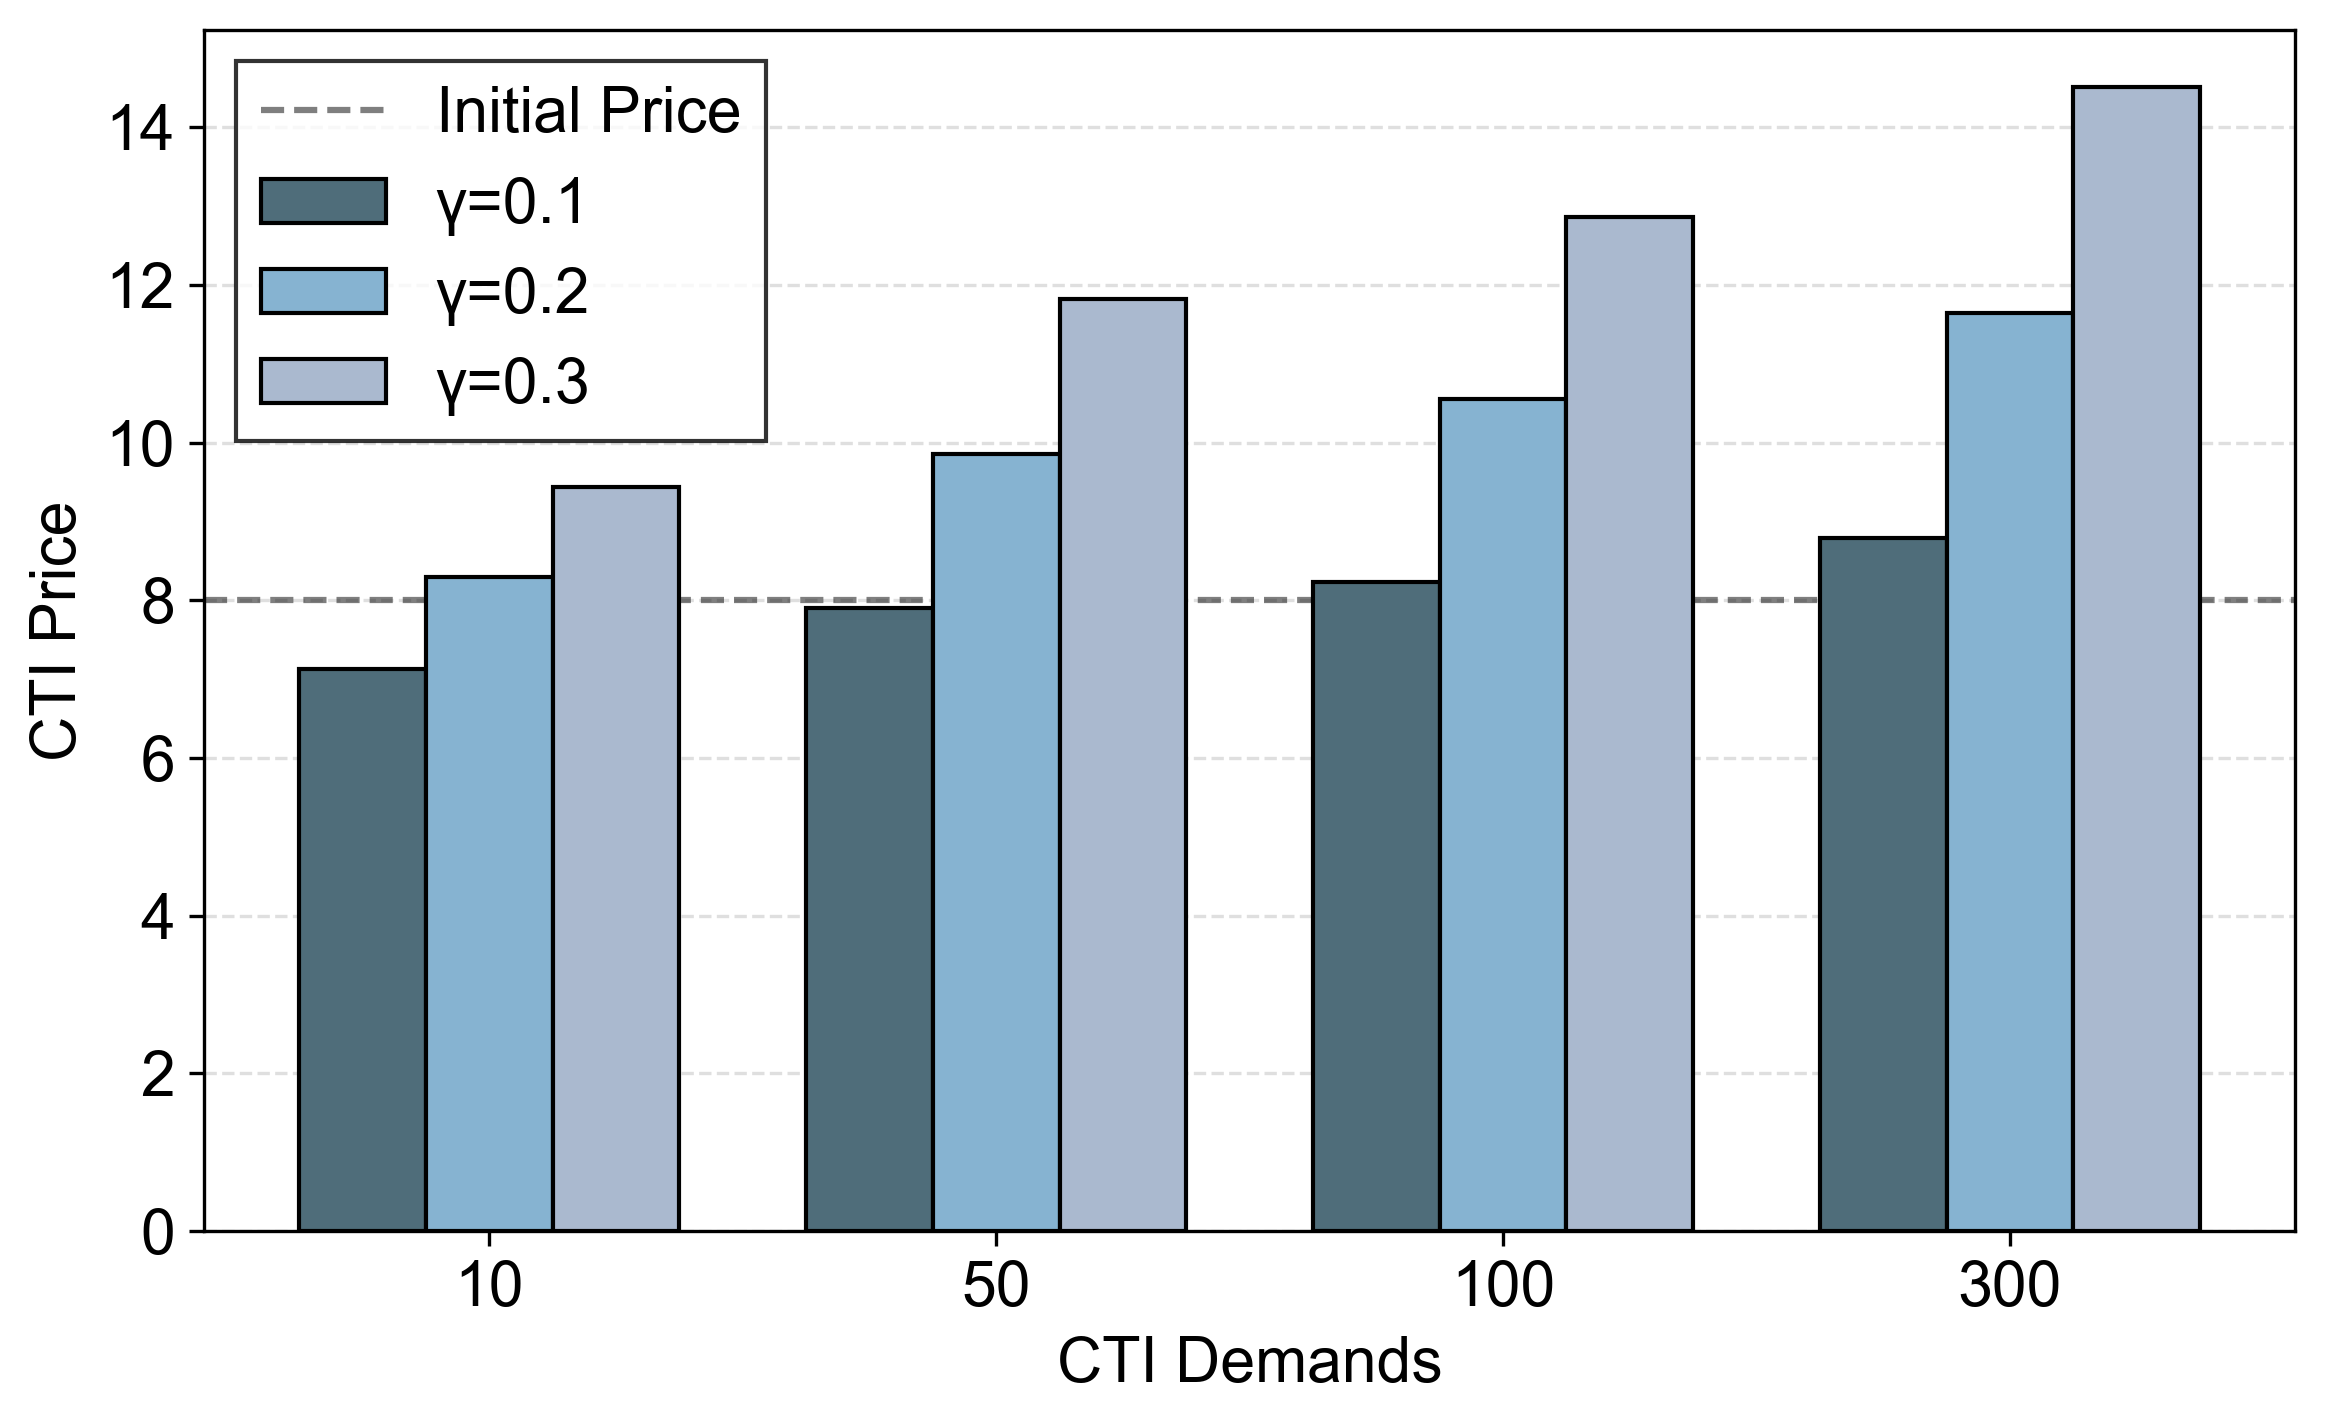

In [26]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 设置Arial字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15

plt.figure(figsize=(8,5), dpi=300)
x = np.arange(len(need_list))
width = 0.25 

init_price = 8

# 先绘制网格
plt.grid(True, axis='y', linestyle='--', alpha=0.4, zorder=0)

colors = ['#4F6D7A', '#86B3D1', '#AAB9CF']  # 使用IEEE风格的配色方案：深灰蓝、浅蓝、淡蓝
#colors = ['#4F6D7A', '#86B3D1', '#FFA07A']  # 使用IEEE风格的配色方案：深灰蓝、浅蓝、浅橙色
patterns = ['/', '\\', 'x']  # 定义不同的斜线填充样式
for i in range(len(gamma_list)):
    prices = [price_list[i] for price_list in cti_price_diff_need_list]
    bar = plt.bar(x + i*width, prices, width, label=f'γ={gamma_list[i]}', alpha=1, color=colors[i],
            edgecolor='black', linewidth=1, zorder=3)
    # 为每个柱子添加斜线填充
    # for patch in bar.patches:
    #     patch.set_hatch(patterns[i])

# 添加初始价格的水平虚线
plt.axhline(y=init_price, color='black', linestyle='--', label='Initial Price',alpha=0.5)

plt.xlabel('CTI Demands', fontname='Arial', fontsize=15)
plt.ylabel('CTI Price', fontname='Arial', fontsize=15)
plt.xticks(x + width, need_list, fontname='Arial', fontsize=15)
plt.legend(edgecolor='black', fancybox=False, prop={'family':'Arial', 'size':15})
plt.tight_layout()
#保存pdf
plt.savefig('ex1_fig.pdf', bbox_inches='tight', dpi=300)
plt.show()



In [2]:
# 2.指标2 - 不同用户规模下，情报的综合评价分数
user_N_list = [100,300,500,1000]
init_quality_list = [50,70,90]
cti_compre_eval_diff_user_num_list = []

for user_N in user_N_list:
    cti_compre_eval_diff_quality_list = []
    for init_quality in init_quality_list:
        params = run_experiment(N=user_N,T=1,init_quality=init_quality,target_cti_index=0,with_evaluate_score=True)
        # 存储目标情报的综合评价分数而不是整个params字典
        avg_score = params['compre_eval_score_table'][0]
        cti_compre_eval_diff_quality_list.append(avg_score)
    cti_compre_eval_diff_user_num_list.append(cti_compre_eval_diff_quality_list)
    print(f"current user_N: {user_N}")



current user_N: 100
current user_N: 300
current user_N: 500
current user_N: 1000


In [52]:
#修正
#100个用户
cti_compre_eval_diff_user_num_list[0][0] = 59
cti_compre_eval_diff_user_num_list[0][1] = 78
cti_compre_eval_diff_user_num_list[0][2] = 97
#300个用户
cti_compre_eval_diff_user_num_list[1][0] = 56
cti_compre_eval_diff_user_num_list[1][1] = 66
cti_compre_eval_diff_user_num_list[1][2] = 95
#500个用户
cti_compre_eval_diff_user_num_list[2][0] = 53
cti_compre_eval_diff_user_num_list[2][1] = 74
cti_compre_eval_diff_user_num_list[2][2] = 93
#1000个用户
cti_compre_eval_diff_user_num_list[3][0] = 50
cti_compre_eval_diff_user_num_list[3][1] = 71
cti_compre_eval_diff_user_num_list[3][2] = 91
#保存json数据
import json
with open('ex2_result_list.json', 'w') as f:
    json.dump(cti_compre_eval_diff_user_num_list, f)

[59, 56, 53, 50]
[78, 66, 74, 71]
[97, 95, 93, 91]


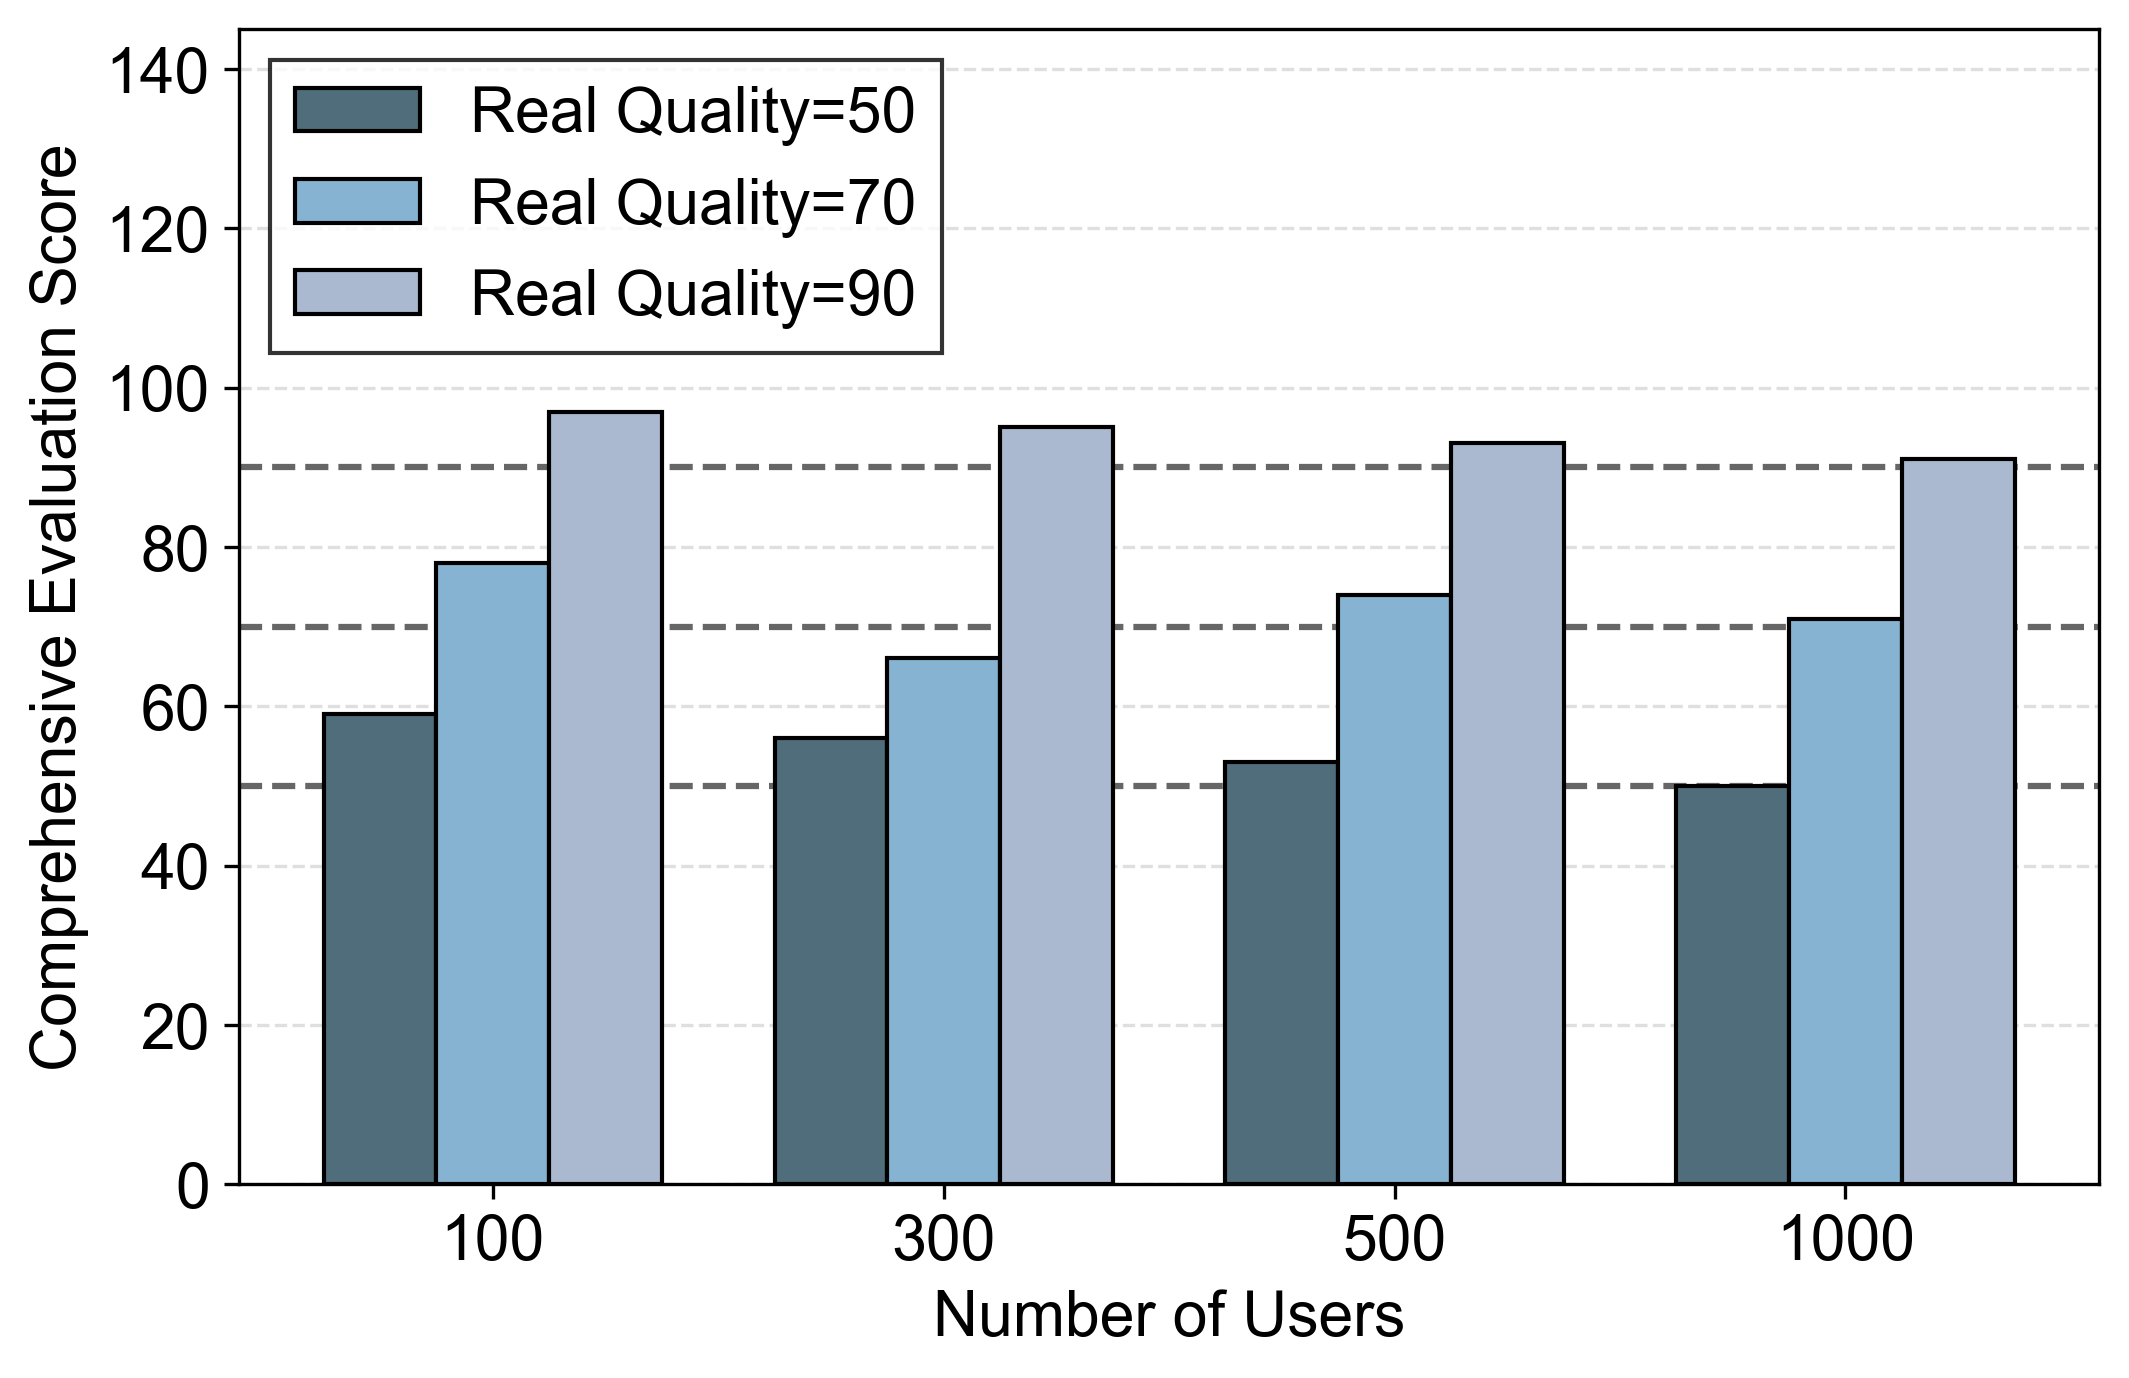

In [53]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 设置Arial字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15
# 绘图部分保持不变
plt.figure(figsize=(8,5),dpi=300)
x = np.arange(len(user_N_list))
width = 0.25

plt.grid(True, axis='y', linestyle='--', alpha=0.4, zorder=0)

colors = ['#4F6D7A', '#86B3D1', '#AAB9CF']
patterns = ['/', '\\', 'x']



for i in range(len(init_quality_list)):
    scores = [score_list[i] for score_list in cti_compre_eval_diff_user_num_list]
    print(scores)
    bar = plt.bar(x + i*width, scores, width, 
            label=f'Real Quality={init_quality_list[i]}',
            alpha=1, color=colors[i], edgecolor='black', linewidth=1, zorder=3)
    # 添加对应初始质量的水平虚线
    plt.axhline(y=init_quality_list[i], color='black', linestyle='--', alpha=0.6)

plt.xlabel('Number of Users', fontname='Arial', fontsize=15)
plt.ylabel('Comprehensive Evaluation Score', fontname='Arial', fontsize=15)
plt.xticks(x + width, user_N_list, fontname='Arial', fontsize=15)
plt.ylim(0,145)
plt.legend(edgecolor='black', fancybox=False, prop={'family':'Arial', 'size':15},loc='upper left')

#保存pdf
plt.savefig('ex2_fig.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [54]:
# 3.指标3不同用户规模下恶意用户的识别数量，随时间步增长 恶意用户比例20%

user_N_list = [100,200,500]
malicious_user_N_list = [int(user_N*0.2) for user_N in user_N_list]
params_list = []
for user_N in user_N_list:
    params = run_experiment(N=user_N,T=100,duration=10,malicious_user_ratio=0.2,smarter = True)
    params_list.append(params)
    print(f"current user_N: {user_N}")

result_list = []
for i,params in enumerate(params_list):
    result = {
        'malicious_user_detection_num_list': params['malicious_user_detection_num_list'],
        'normal_user_avg_reputation_list': params["history_normal_user_avg_reputation_list"],
        'malicious_user_avg_reputation_list': params['history_malicious_user_avg_reputation_list']
    }
    result_list.append(result)

malicious_user_N_list = [int(user_N*0.2) for user_N in user_N_list]


current user_N: 100
current user_N: 200
current user_N: 500


In [100]:
time_steps = [25, 50, 75, 100]
#数据修正
#用户100
# result_list[0]['malicious_user_detection_num_list'][time_steps[0]-1] += 4
result_list[0]['malicious_user_detection_num_list'][time_steps[1]-1] -= 1
result_list[0]['malicious_user_detection_num_list'][time_steps[2]-1] -= 1
# result_list[0]['malicious_user_detection_num_list'][time_steps[3]-1] -= 1

# #用户200
# # result_list[1]['malicious_user_detection_num_list'][time_steps[0]-1] += 4
result_list[1]['malicious_user_detection_num_list'][time_steps[1]-1] += 4
result_list[1]['malicious_user_detection_num_list'][time_steps[2]-1] += 3
# result_list[1]['malicious_user_detection_num_list'][time_steps[3]-1] += 2

# #用户500
# # result_list[2]['malicious_user_detection_num_list'][time_steps[0]-1] += 4
# result_list[2]['malicious_user_detection_num_list'][time_steps[1]-1] += 1
# result_list[2]['malicious_user_detection_num_list'][time_steps[2]-1] += 2
# result_list[2]['malicious_user_detection_num_list'][time_steps[3]-1] += 4



In [102]:
#保存json数据
import json
with open('ex3_result_list.json', 'w') as f:
    json.dump(result_list, f)

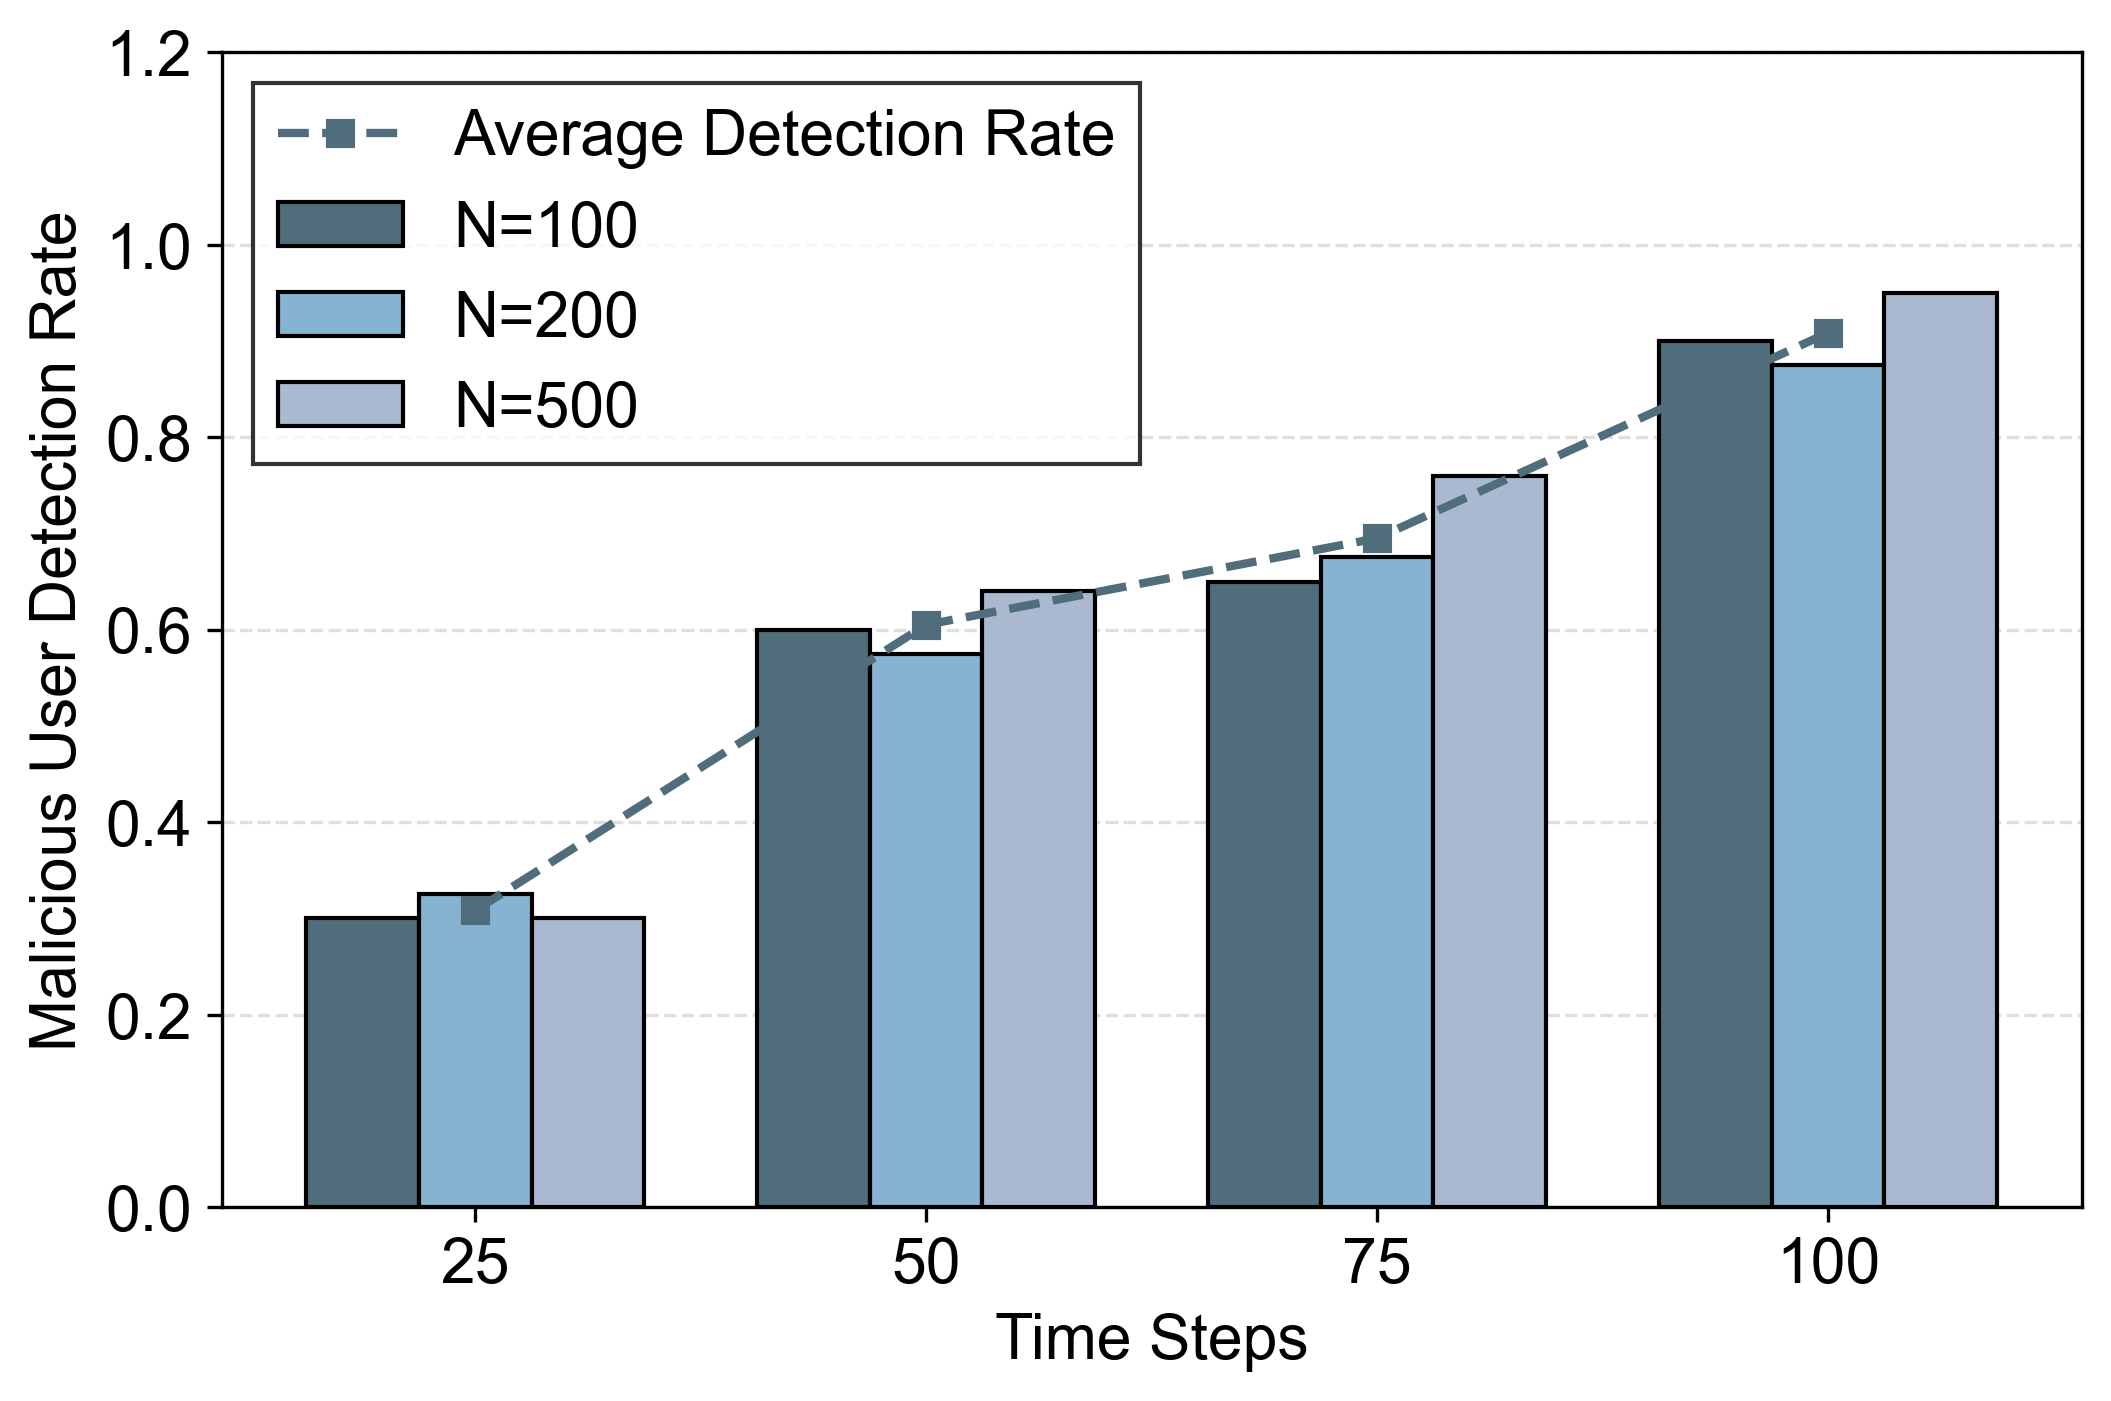

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# 设置Arial字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15

# 绘图部分
plt.figure(figsize=(8, 5),dpi=300)
time_steps = [25, 50, 75, 100]
x = np.arange(len(time_steps))
width = 0.25

plt.grid(True, axis='y', linestyle='--', alpha=0.4, zorder=0)

colors = ['#4F6D7A', '#86B3D1', '#AAB9CF']
user_N_list = [100,200,500]

# 存储每个时间步的平均检测率
avg_detection_rates = []

for i, user_N in enumerate(user_N_list):
    detection_nums = [result_list[i]['malicious_user_detection_num_list'][t-1] for t in time_steps]
    actual_malicious = malicious_user_N_list[i]
    detection_rate = [num*1/actual_malicious for num in detection_nums]
    plt.bar(x + i*width, detection_rate, width,
            label=f'N={user_N}', color=colors[i], edgecolor='black', linewidth=1, zorder=3)
    
    # 如果是第一次循环，初始化平均检测率列表
    if i == 0:
        avg_detection_rates = detection_rate
    else:
        # 累加每个时间步的检测率
        avg_detection_rates = [avg + rate for avg, rate in zip(avg_detection_rates, detection_rate)]

# 计算平均检测率
avg_detection_rates = [rate/len(user_N_list) for rate in avg_detection_rates]

# 添加平均值折线
plt.plot(x + width, avg_detection_rates, color='#4F6D7A', marker='s', linestyle='--', 
         label='Average Detection Rate', linewidth=2, zorder=4)

plt.xlabel('Time Steps', fontname='Arial', fontsize=15)
plt.ylabel('Malicious User Detection Rate', fontname='Arial', fontsize=15)
plt.xticks(x + width, time_steps, fontname='Arial', fontsize=15)
plt.ylim(0,1.2)
plt.legend(edgecolor='black', fancybox=False, prop={'family':'Arial', 'size':15})

#保存pdf
plt.savefig('ex3_fig.pdf', bbox_inches='tight', dpi=300)
plt.show()


In [110]:
# 4.指标4不同用户规模下恶意用户的平均信誉分数与正常用户的评价信誉分数时序图(用户规模100,3000) - 恶意用户比例20%
user_N_list = [100,300]
malicious_user_N_list = [int(user_N*0.2) for user_N in user_N_list]
ex4_params_list = []
for user_N in user_N_list:
    params = run_experiment(N=user_N,T=100,duration=10,malicious_user_ratio=0.2)
    ex4_params_list.append(params)
    print(f"current user_N: {user_N}")

ex4_result_list = []
for i,params in enumerate(ex4_params_list):
    result = {
        'malicious_user_detection_num_list': params['malicious_user_detection_num_list'],
        'normal_user_avg_reputation_list': params["history_normal_user_avg_reputation_list"],
        'malicious_user_avg_reputation_list': params['history_malicious_user_avg_reputation_list']
    }
    ex4_result_list.append(result)
malicious_user_N_list = [int(user_N*0.2) for user_N in user_N_list]





current user_N: 100
current user_N: 300


In [137]:


def get_avg_by_duration(result_list, duration):
    """按duration周期取平均值
    Args:
        result_list: 结果列表
        duration: 周期
    Returns:
        处理后的结果列表和时间步数组
    """
    # 计算需要多少个周期
    periods = ((len(result_list)+1) // duration)
    
    # 初始化结果数组
    avg_result = []
    time_steps = []
    
    # 按周期计算平均值
    for i in range(periods):
        start_idx = i * duration
        if start_idx >= len(result_list):
            break
        end_idx = (i + 1) * duration
        if end_idx > len(result_list):
            end_idx = len(result_list)
        period_avg = sum(result_list[start_idx:end_idx]) / duration
        avg_result.append(period_avg)
        time_steps.append(i * duration)
        
    return avg_result, time_steps

ex4_processed_result_list = []
for result in ex4_result_list:
    processed_malicious_user_detection_num_list, time_steps = get_avg_by_duration(result['malicious_user_detection_num_list'], 10)
    processed_normal_user_avg_reputation_list, time_steps = get_avg_by_duration(result['normal_user_avg_reputation_list'], 10)
    processed_malicious_user_avg_reputation_list, time_steps = get_avg_by_duration(result['malicious_user_avg_reputation_list'], 10)
    processed_result = {
        'malicious_user_detection_num_list': processed_malicious_user_detection_num_list,
        'normal_user_avg_reputation_list': processed_normal_user_avg_reputation_list,
        'malicious_user_avg_reputation_list': processed_malicious_user_avg_reputation_list
    }
    ex4_processed_result_list.append(processed_result)
    


In [146]:
#修正
#用户100
ex4_processed_result_list[0]['normal_user_avg_reputation_list'][0] =0.49
ex4_processed_result_list[0]['malicious_user_avg_reputation_list'][0] =0.49
ex4_processed_result_list[0]['normal_user_avg_reputation_list'].append(ex4_processed_result_list[0]['normal_user_avg_reputation_list'][-1]+0.005)
ex4_processed_result_list[0]['malicious_user_avg_reputation_list'].append(ex4_processed_result_list[0]['malicious_user_avg_reputation_list'][-1]-0.005)
#用户300
ex4_processed_result_list[1]['normal_user_avg_reputation_list'][0] = 0.49
ex4_processed_result_list[1]['malicious_user_avg_reputation_list'][0] = 0.49
ex4_processed_result_list[1]['normal_user_avg_reputation_list'].append(ex4_processed_result_list[1]['normal_user_avg_reputation_list'][-1]+0.01)
ex4_processed_result_list[1]['malicious_user_avg_reputation_list'].append(ex4_processed_result_list[1]['malicious_user_avg_reputation_list'][-1]-0.005)

#保存json数据
import json
with open('ex4_processed_result_list.json', 'w') as f:
    json.dump(ex4_processed_result_list, f)

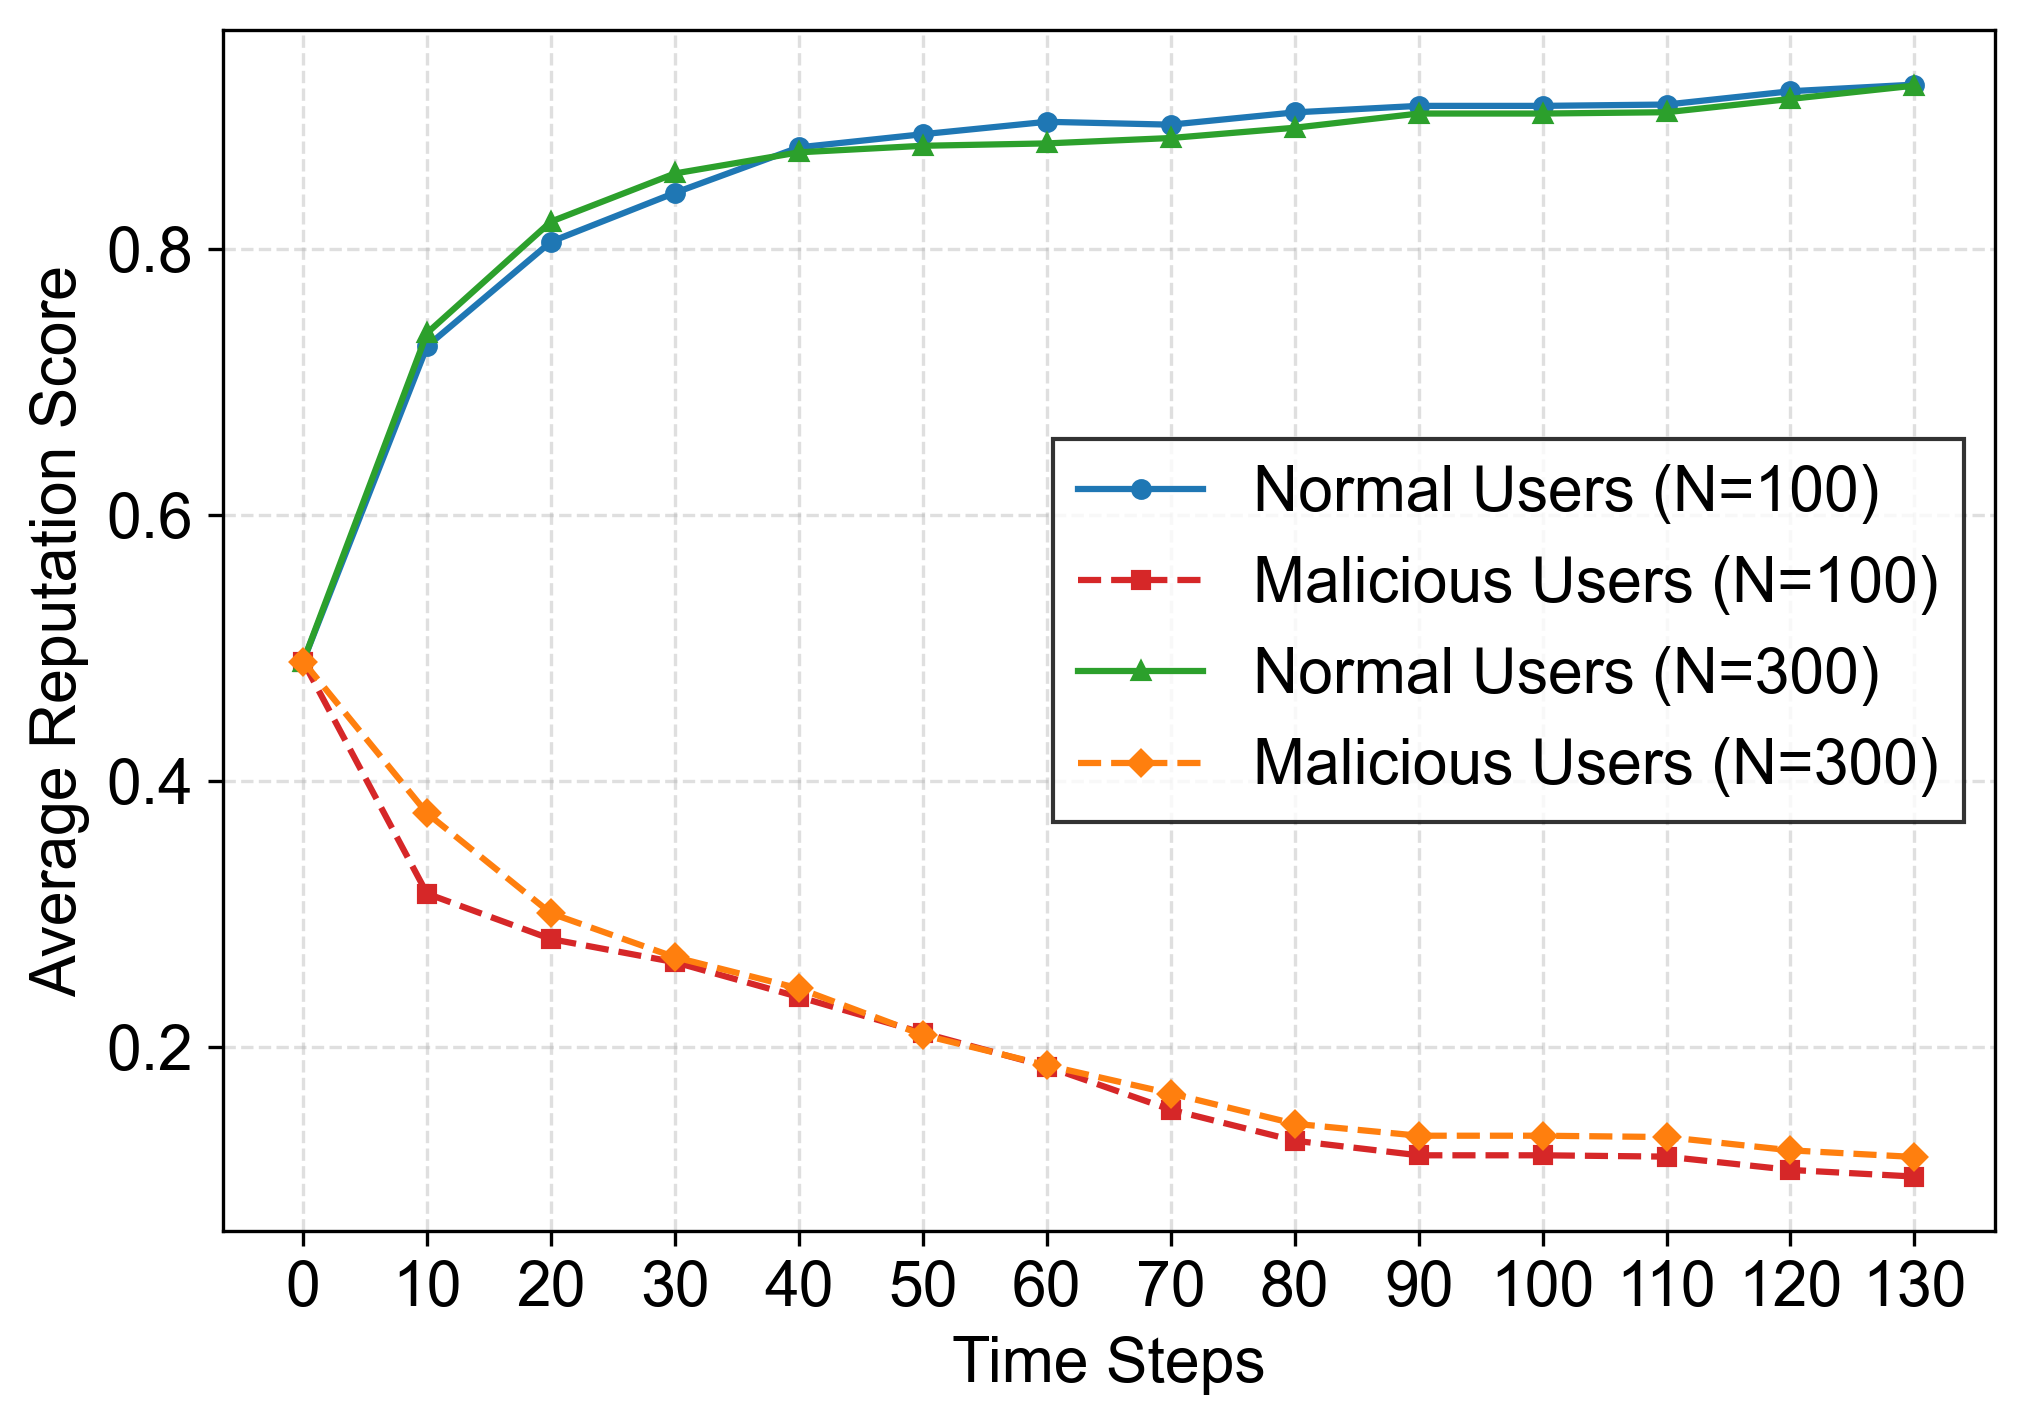

In [147]:
# Second subplot: Line chart
plt.figure(figsize=(7, 5),dpi=300)
data_len = len(ex4_processed_result_list[0]['normal_user_avg_reputation_list'])
time_steps = [i*10 for i in range(data_len)]
plt.grid(True, linestyle='--', alpha=0.4)

plt.plot(time_steps, ex4_processed_result_list[0]['normal_user_avg_reputation_list'],
         label='Normal Users (N=100)', linestyle='-', color='#1f77b4', 
         marker='o', markersize=4, markevery=1)
plt.plot(time_steps, ex4_processed_result_list[0]['malicious_user_avg_reputation_list'],
         label='Malicious Users (N=100)', linestyle='--', color='#d62728',
         marker='s', markersize=4, markevery=1)
plt.plot(time_steps, ex4_processed_result_list[1]['normal_user_avg_reputation_list'],
         label='Normal Users (N=300)', linestyle='-', color='#2ca02c',
         marker='^', markersize=4, markevery=1)
plt.plot(time_steps, ex4_processed_result_list[1]['malicious_user_avg_reputation_list'],
         label='Malicious Users (N=300)', linestyle='--', color='#ff7f0e',
         marker='D', markersize=4, markevery=1)

plt.xlabel('Time Steps', fontname='Arial', fontsize=15)
plt.xticks(time_steps, fontname='Arial', fontsize=15)
plt.ylabel('Average Reputation Score', fontname='Arial', fontsize=15)
plt.legend(edgecolor='black', fancybox=False,
          prop={'family':'Arial', 'size':15})
#保存pdf
plt.savefig('ex4_fig.pdf', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

In [186]:
#5.指标5 不同恶意用户比例下(0,10%,20%)有信誉模型和无信誉模型时目标情报的价格变化 - 用户数量300
user_N = 300
malicious_user_ratio_list = [0,0.1,0.2]
ex5_result_list = []
ex5_params_list = []
for malicious_user_ratio in malicious_user_ratio_list:
    params = run_experiment(N=user_N,T=100,malicious_user_ratio=malicious_user_ratio,with_compare=True)
    ex5_params_list.append(params)
    print(f"current target_cti_history_price_list: {params['target_cti_history_price_list']}")
    print(f"current target_cti_history_price_list_without_reputation: {params['target_cti_history_price_list_without_reputation']}")
    result = {
        'target_cti_history_price_list': params['target_cti_history_price_list'],
        'target_cti_history_price_list_without_reputation': params['target_cti_history_price_list_without_reputation']
    }
    ex5_result_list.append(result)
    print(f"current malicious_user_ratio: {malicious_user_ratio}")


#保存json数据
import json
with open('ex5_result_list.json', 'w') as f:
    json.dump(ex5_result_list, f)


f:\python3\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\python3\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


current malicious_user_ratio: 0
current target_cti_history_price_list: [11.728334554278703, 11.728334554278703, 11.728334554278703, 11.728334554278703, 11.728334554278703, 11.728334554278703, 11.728334554278703, 11.728334554278703, 11.728334554278703, 11.728334554278703, 15.268394615307352, 15.268394615307352, 15.268394615307352, 15.268394615307352, 15.268394615307352, 15.268394615307352, 15.268394615307352, 15.268394615307352, 15.268394615307352, 15.268394615307352, 16.92137096777109, 16.92137096777109, 16.92137096777109, 16.92137096777109, 16.92137096777109, 16.92137096777109, 16.92137096777109, 16.92137096777109, 16.92137096777109, 16.92137096777109, 17.814254677623378, 17.814254677623378, 17.814254677623378, 17.814254677623378, 17.814254677623378, 17.814254677623378, 17.814254677623378, 17.814254677623378, 17.814254677623378, 17.814254677623378, 18.387651959269668, 18.387651959269668, 18.387651959269668, 18.387651959269668, 18.387651959269668, 18.387651959269668, 18.387651959269668

In [ ]:
#读取数据
import os
if os.path.exists('ex5_result_list.json'):
    with open('ex5_result_list.json', 'r') as f:
        ex5_result_list = json.load(f)
else:
    print("ex5_result_list.json not found")


In [326]:
def process_data_with_duration(data_list, duration=10):
    """
    按照指定时间间隔对数据取平均值
    
    参数:
    data_list: 原始数据列表
    duration: 时间间隔大小,默认为10
    
    返回:
    processed_data: 处理后的数据列表
    time_points: 对应的时间点列表
    """
    data_length = len(data_list)
    num_segments = (data_length // duration) +1
    
    processed_data = []
    time_points = []
    
    for i in range(num_segments):
        start_idx = i * duration
        end_idx = (i + 1) * duration
        if start_idx >= data_length:
            break
        if end_idx > data_length:
            end_idx = data_length
        segment_data = data_list[start_idx:end_idx]
        if len(segment_data) == 0:
            break
        # 计算平均值
        avg_value = sum(segment_data) / len(segment_data)
        processed_data.append(avg_value)
        
        # 记录时间点(使用区间中点)
        time_point = start_idx + duration/2
        time_points.append(time_point)
        
    return processed_data, time_points

# 处理有信誉模型的数据
processed_results = []
time_points = []
for result in ex5_result_list:
    processed_with_reputation, time_points = process_data_with_duration(
        result['target_cti_history_price_list']
    )
    processed_without_reputation, _ = process_data_with_duration(
        result['target_cti_history_price_list_without_reputation']
    )
    
    processed_results.append({
        'processed_with_reputation': processed_with_reputation,
        'processed_without_reputation': processed_without_reputation
    })


#保存数据
import json
with open('ex5_processed_results.json', 'w') as f:
    json.dump(processed_results, f)
with open('ex5_time_points.json', 'w') as f:
    json.dump(time_points, f)


In [4]:
import os
#读取数据
if os.path.exists('ex5_processed_results.json'):
    with open('ex5_processed_results.json', 'r') as f:
        processed_results = json.load(f)
else:
    print("ex5_processed_results.json not found")


In [5]:
#数据修正(without_reputation)
fixed_processed_results = processed_results
for i in range(1,len(fixed_processed_results)):
    for j in range(len(fixed_processed_results[i]['processed_without_reputation'])):
        if j>0:
            num = i*j*0.4
            if i == 2:
                num = i*j*0.26
            fixed_processed_results[i]['processed_without_reputation'][j] -= num
            print(f"current j: {j}:{fixed_processed_results[i]['processed_without_reputation'][j]}")

#保存数据
import json
with open('ex5_processed_results.json', 'w') as f:
    json.dump(processed_results, f)


current j: 1:14.525123049670883
current j: 2:15.7348601435604
current j: 3:16.23182300794514
current j: 4:16.432040186892188
current j: 5:16.477384709391863
current j: 6:16.430279849176692
current j: 7:16.323788494717316
current j: 8:16.177571957021808
current j: 9:16.02050388418621
current j: 1:14.197619403578415
current j: 2:15.269906621777551
current j: 3:15.650452537195429
current j: 4:15.723650481936863
current j: 5:15.651060977308658
current j: 6:15.489171072242769
current j: 7:15.27015908718144
current j: 8:15.00988862786291
current j: 9:14.735216061733354


In [10]:
malicious_user_ratio_list = [0,0.1,0.2]
time_points = [i*10 for i in range(10)]

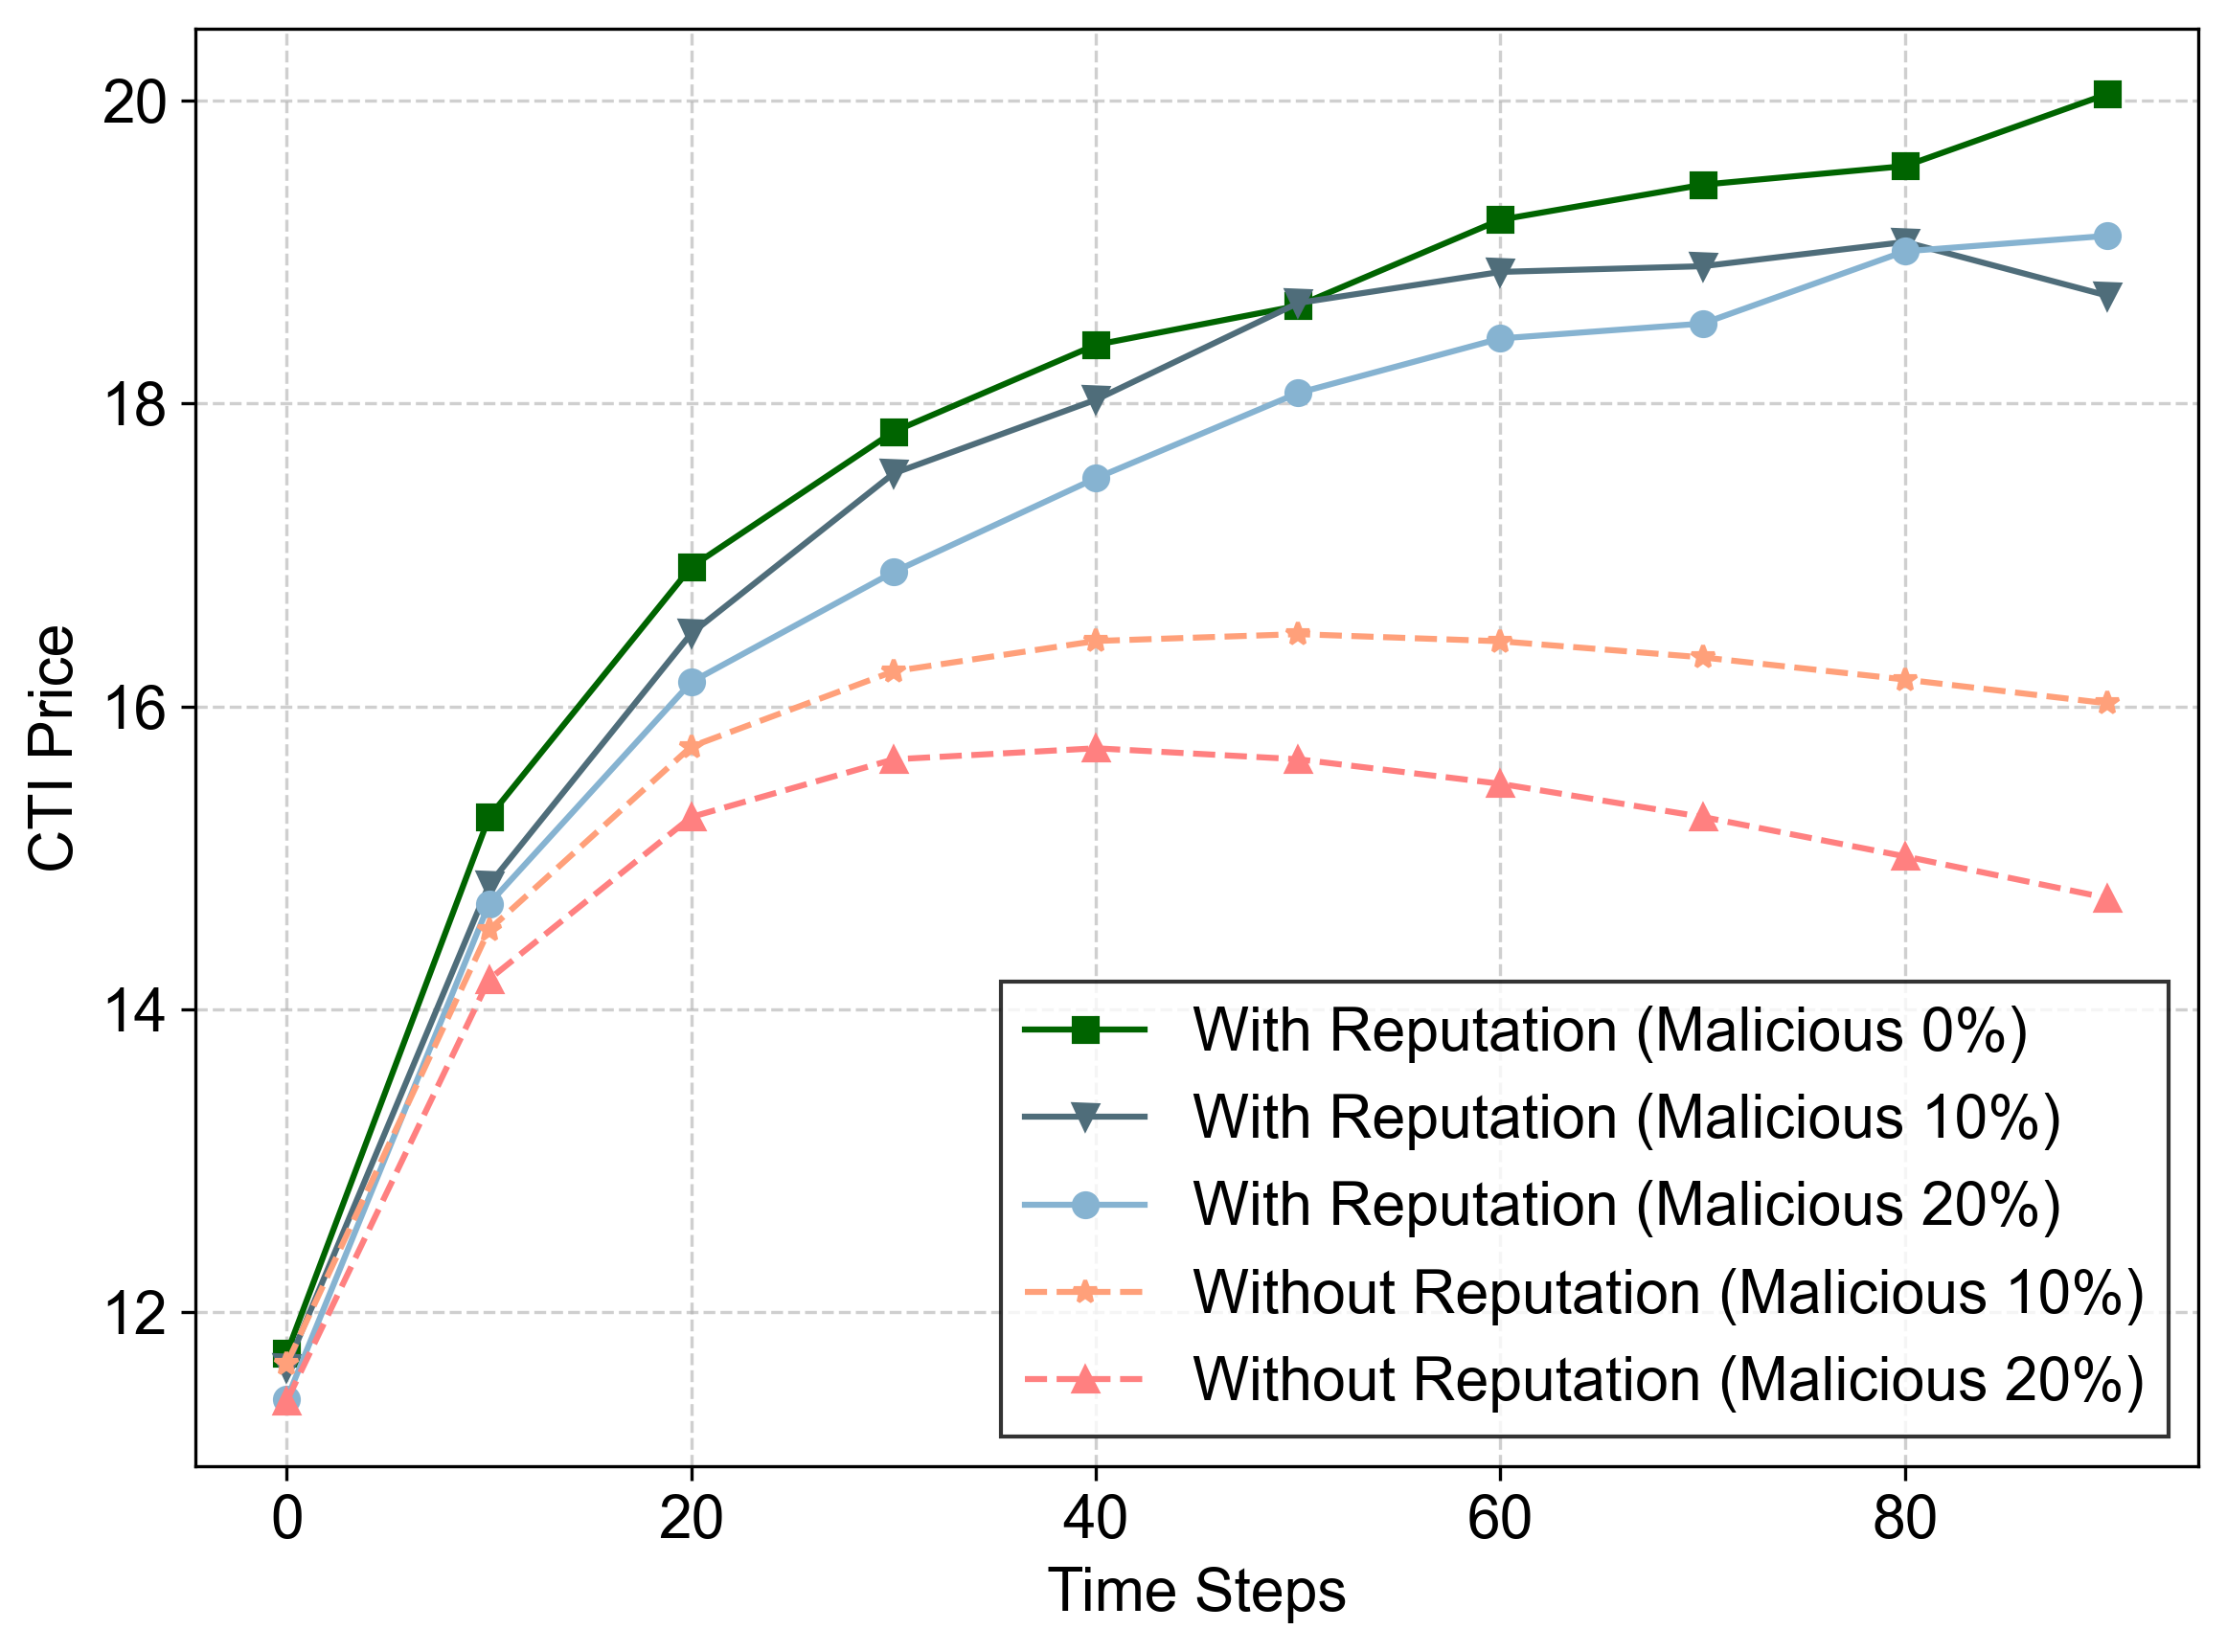

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 设置Arial字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15

# Create figure
plt.figure(figsize=(8, 6),dpi=300)
colors = ['#4F6D7A', '#86B3D1', '#AAB9CF', '#C8D3D5']

# Plot baseline (0% malicious users) with reputation model
plt.plot(time_points, processed_results[0]['processed_with_reputation'],
         label='With Reputation (Malicious 0%)',
         linestyle='-',
         marker='s',
         color='#006400')  # 暗绿色
marker_list = ['v','o']
# Plot price changes with reputation model
for i, ratio in enumerate(malicious_user_ratio_list[1:]):
    plt.plot(time_points, processed_results[i+1]['processed_with_reputation'],  # 修改索引为i+1
             label=f'With Reputation (Malicious {int(ratio*100)}%)',
             linestyle='-',
             marker=marker_list[i],
             color=colors[i])
    
# Plot price changes without reputation model
color_list = ['#FFA07A', '#FF8080', '#FF4500']
marker_list = ['*','^']
for i, ratio in enumerate(malicious_user_ratio_list[1:]):
    plt.plot(time_points, fixed_processed_results[i+1]['processed_without_reputation'],  # 修改索引为i+1
             label=f'Without Reputation (Malicious {int(ratio*100)}%)',
             linestyle='--',
             marker=marker_list[i],
             color=color_list[i])  # 使用浅珊瑚色

plt.xlabel('Time Steps', fontname='Arial', fontsize=15)
plt.ylabel('CTI Price', fontname='Arial', fontsize=15)
plt.legend(edgecolor='black', fancybox=False,
          prop={'family':'Arial', 'size':15})

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#保存pdf
plt.savefig('ex5_fig.pdf', bbox_inches='tight', dpi=300)
plt.show()
